In [1]:
import numpy as np
import numpy_groupies as npg

import itertools
import string
import pickle
import os

import tqdm.notebook as tqdm

import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from utils.surf import  smooth_adjacent_values
from utils.vis_3d import BrainSurface
from utils.burst import compute_e_values, find_longest_segment
from utils.pyutils import create_subsystem_map
from utils.io import read_seeg_parcel_names
from utils.colors import ripples_blue, ripples_red, okabe
from utils.plot import draw_four_views

%config InlineBackend.figure_format = 'jpg'

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
l:\nttk-data3\palva\Vlad\projects_backup\seeg_meso_submission\utils\burst.py:40: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def acf_mass_kurtosis(arr, threshold=2.42):


In [2]:
# it would be possible to make a single function and just pass np.less/greater
# but two functions look more clear IMO

def compute_stable_fraction(arr, axis=0):
    res = (arr > 1.05).astype(float)
    res[np.isnan(arr)] = np.nan

    return np.nanmean(res, axis=axis)

def compute_burst_fraction(arr, axis=0):
    res = (arr < 0.95).astype(float)
    res[np.isnan(arr)] = np.nan

    return np.nanmean(res, axis=axis)

In [3]:
n_cortical = 400

In [4]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)

data_color = okabe[0]
noise_color = okabe[7]
red_color = okabe[2]
orange_color = okabe[1]
green_color = okabe[3]

In [5]:
submission_data_path = os.path.join('..', '..', 'meso_submission_data')

In [6]:
f_vals = [2]

while f_vals[~0] < 99:
    f_vals.append(f_vals[~0]*1.05)

f_vals = np.array(f_vals)

lags_cycles = np.arange(0,20,0.1)

seeg_parcels_dirpath = os.path.join(submission_data_path, 'SEEG')
seeg_parcel_names = read_seeg_parcel_names(n_cortical, root=seeg_parcels_dirpath)

In [7]:
counter_known = np.load(os.path.join(submission_data_path, 'SEEG', 'counter_known.npy'))
adjacency_matrix = np.load(os.path.join(submission_data_path, 'figure_7', 'yeo17_400_adjacency_matrix.npy'))

In [8]:
meg_burst_data = pickle.load(open(os.path.join(submission_data_path, 'figure_7', 'meg_burst_data.pickle'), 'rb'))

meg_burst_coeffs = meg_burst_data['meg_burst_coeffs']
meg_parcel_names = meg_burst_data['meg_parcel_names']

In [9]:
n_boot_rounds = 1000

meg_burst_coeffs_boot = np.zeros((n_boot_rounds, *meg_burst_coeffs.shape[1:]))
meg_stable_fraction_boot = np.zeros((n_boot_rounds, *meg_burst_coeffs.shape[1:]))
meg_burst_fraction_boot = np.zeros((n_boot_rounds, *meg_burst_coeffs.shape[1:]))

for i in range(n_boot_rounds):
    round_indices = np.random.choice(np.arange(meg_burst_coeffs.shape[0]), size=meg_burst_coeffs.shape[0])
    
    meg_burst_coeffs_boot[i] = np.nanmean(meg_burst_coeffs[round_indices], axis=0)
    meg_stable_fraction_boot[i] = compute_stable_fraction(meg_burst_coeffs[round_indices], axis=0)
    meg_burst_fraction_boot[i] = compute_burst_fraction(meg_burst_coeffs[round_indices], axis=0)

C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\148552325.py:10: RuntimeWarning: Mean of empty slice
  meg_burst_coeffs_boot[i] = np.nanmean(meg_burst_coeffs[round_indices], axis=0)
C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\3419966608.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(res, axis=axis)
C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\3419966608.py:14: RuntimeWarning: Mean of empty slice
  return np.nanmean(res, axis=axis)


In [10]:
cohort_seeg_burst_known = np.load(os.path.join(submission_data_path, 'figure_7', 'cohort_seeg_burst_known.npy'))

n_subjs = cohort_seeg_burst_known.shape[0]

seeg_burst_values_boot = np.zeros((n_boot_rounds, n_cortical, len(f_vals)))
seeg_stable_fraction_boot = np.zeros((n_boot_rounds, n_cortical, len(f_vals)))
seeg_burst_fraction_boot = np.zeros((n_boot_rounds, n_cortical, len(f_vals)))

for i in range(n_boot_rounds):
    round_indices = np.random.choice(np.arange(n_subjs), size=n_subjs)

    round_seeg_burst_known = cohort_seeg_burst_known[round_indices]

    seeg_burst_values_boot[i] = np.nanmean(round_seeg_burst_known, axis=0)

    round_stable_fraction = (round_seeg_burst_known > 1.05).astype(float)
    round_stable_fraction[np.isnan(round_seeg_burst_known)] = np.nan

    round_burst_fraction = (round_seeg_burst_known < 0.95).astype(float)
    round_burst_fraction[np.isnan(round_seeg_burst_known)] = np.nan

    seeg_stable_fraction_boot[i] = np.nanmean(round_stable_fraction, axis=0)
    seeg_burst_fraction_boot[i] = np.nanmean(round_burst_fraction, axis=0)


C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\2349549096.py:14: RuntimeWarning: Mean of empty slice
  seeg_burst_values_boot[i] = np.nanmean(round_seeg_burst_known, axis=0)
C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\2349549096.py:22: RuntimeWarning: Mean of empty slice
  seeg_stable_fraction_boot[i] = np.nanmean(round_stable_fraction, axis=0)
C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\2349549096.py:23: RuntimeWarning: Mean of empty slice
  seeg_burst_fraction_boot[i] = np.nanmean(round_burst_fraction, axis=0)


In [12]:
# fsaverage_path = os.path.join(submission_data_path, 'anatomy', 'fsaverage')

# brain_surf_lh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_400Parcels_17Networks_order', 
#                              hemis=['lh'], surface='inflated')
# brain_surf_rh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_400Parcels_17Networks_order', 
#                              hemis=['rh'], surface='inflated')

brain_anatomy = pickle.load(open(os.path.join(submission_data_path, 'anatomy', 'brain_anatomy.pickle'), 'rb'))

brain_surf_lh = brain_anatomy['lh']
brain_surf_rh = brain_anatomy['rh']

surf_3d_parcel_names = brain_surf_lh.parcel_names[1:] + brain_surf_rh.parcel_names[1:]
brain_3d_surfaces = [brain_surf_lh, brain_surf_rh]

In [13]:
cortical_parcels = [n for n in seeg_parcel_names[-402:] if not('unknown' in n.lower() or 'background' in n.lower())]
cortical_subsystems = np.array([n.split('_')[2] for n in cortical_parcels])

subsystem_to_index = create_subsystem_map(cortical_subsystems)
subsystem_indices = np.array([subsystem_to_index[s] for s in cortical_subsystems])

In [15]:
seeg_parcel_names_new = pickle.load(open(os.path.join(submission_data_path, 'figure_7', 'seeg_new_names_yeo17_400.pickle'), 'rb'))

# seeg_comm_to_nodes = pickle.load(open(os.path.join(submission_data_path, 'figure_7', 'seeg_comm_to_nodes.pickle'), 'rb'))
# meg_comm_to_nodes = pickle.load(open(os.path.join(submission_data_path, 'figure_7', 'meg_comm_to_nodes.pickle'), 'rb'))

seeg_communities_new = pickle.load(open(os.path.join(submission_data_path, 'figure_7', 'seeg_communities_new.pickle'), 'rb'))
meg_communities_new = pickle.load(open(os.path.join(submission_data_path, 'figure_7', 'meg_communities_new.pickle'), 'rb'))

In [16]:
burst_coeff_examples = pickle.load(open(os.path.join(submission_data_path, 'figure_7', 'burst_coeff_example.pickle'), 'rb'))

bursty_pacf_normed = burst_coeff_examples['bursty_pacf']/burst_coeff_examples['noise_pacf']
stable_pacf_normed = burst_coeff_examples['stable_pacf']/burst_coeff_examples['noise_pacf']

In [17]:
labels_grouped = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'TempPar']
labels_grouped_indices = [0.5, 2.5, 4.5, 6.5, 8.5, 11, 14, 16]

In [18]:
seeg_burst_values_mean = np.nanmean(seeg_burst_values_boot, axis=(0,1))
seeg_burst_values_ci = np.percentile(np.nanmean(seeg_burst_values_boot, axis=1), (2.5,97.5), axis=0)

meg_burst_values_mean = np.nanmean(meg_burst_coeffs_boot, axis=(0,-1))
meg_burst_values_ci = np.percentile(np.nanmean(meg_burst_coeffs_boot, axis=-1), (2.5,97.5), axis=0)

seeg_burst_fraction_mean = np.nanmean(seeg_burst_fraction_boot, axis=(0,1))
seeg_burst_fraction_ci = np.percentile(np.nanmean(seeg_burst_fraction_boot, axis=1), (2.5, 97.5), axis=0)

seeg_stable_fraction_mean = np.nanmean(seeg_stable_fraction_boot, axis=(0,1))
seeg_stable_fraction_ci = np.percentile(np.nanmean(seeg_stable_fraction_boot, axis=1), (2.5, 97.5), axis=0)

meg_burst_fraction_mean = np.nanmean(meg_burst_fraction_boot, axis=(0,-1))
meg_burst_fraction_ci = np.percentile(np.nanmean(meg_burst_fraction_boot, axis=-1), (2.5, 97.5), axis=0)

meg_stable_fraction_mean = np.nanmean(meg_stable_fraction_boot, axis=(0,-1))
meg_stable_fraction_ci = np.percentile(np.nanmean(meg_stable_fraction_boot, axis=-1), (2.5, 97.5), axis=0)

C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\345376447.py:2: RuntimeWarning: Mean of empty slice
  seeg_burst_values_ci = np.percentile(np.nanmean(seeg_burst_values_boot, axis=1), (2.5,97.5), axis=0)
C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\345376447.py:4: RuntimeWarning: Mean of empty slice
  meg_burst_values_mean = np.nanmean(meg_burst_coeffs_boot, axis=(0,-1))
C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\345376447.py:5: RuntimeWarning: Mean of empty slice
  meg_burst_values_ci = np.percentile(np.nanmean(meg_burst_coeffs_boot, axis=-1), (2.5,97.5), axis=0)
C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\345376447.py:8: RuntimeWarning: Mean of empty slice
  seeg_burst_fraction_ci = np.percentile(np.nanmean(seeg_burst_fraction_boot, axis=1), (2.5, 97.5), axis=0)
C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\345376447.py:11: RuntimeWarning: Mean of empty slice
  seeg_stable_fraction_ci = np.percentile(np.nanmean(seeg_stable_fraction_boot, axis=1), (2.5

C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\1636584811.py:108: RuntimeWarning: Mean of empty slice
  osc_fraction = np.nanmean(osc_data[..., indices], axis=-1)
C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\1636584811.py:156: RuntimeWarning: Mean of empty slice
  values = np.nanmean(data[..., indices], axis=(0,-1))
C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_2660\1636584811.py:220: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


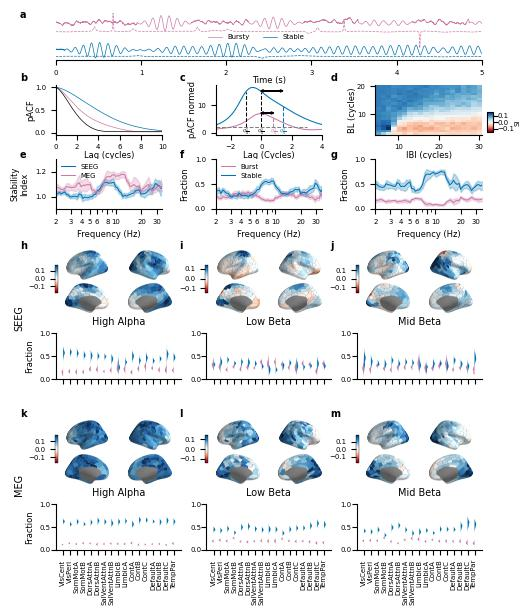

In [21]:
fig = plt.figure(figsize=(5.5, 7), dpi=100)

main_spec = fig.add_gridspec(nrows=3, ncols=1, hspace=0.25, height_ratios=[3,2,2])

top_spec = main_spec[0].subgridspec(ncols=3, nrows=3, wspace=0.5, hspace=0.5)
mid_spec = main_spec[1].subgridspec(ncols=3, nrows=2, hspace=0.3, height_ratios=[3,2])
bot_spec = main_spec[2].subgridspec(ncols=3, nrows=2, hspace=0.3, height_ratios=[3,2])

legend_elements = [Patch(facecolor=data_color, label='Stable'),
                   Patch(facecolor=red_color, label='Burst')]

top_axes = np.empty((3,3), dtype=object)

top_axes[0,0] = fig.add_subplot(top_spec[0, :3])

for i in range(1,3):
    for j in range(3):
        top_axes[i,j] = fig.add_subplot(top_spec[i,j])


top_axes[0,0].plot(np.arange(5000)/1000, burst_coeff_examples['bursty_signal'][:5000], color=ripples_red, lw=0.5, label='Bursty')
top_axes[0,0].plot(np.arange(4999)/1000, burst_coeff_examples['bursty_if'][:4999] - 30, color=ripples_red, ls='--', lw=0.5)

top_axes[0,0].plot(np.arange(5000)/1000, burst_coeff_examples['stable_signal'][:5000] - 65, color=ripples_blue, lw=0.5, label='Stable')
top_axes[0,0].plot(np.arange(4999)/1000, burst_coeff_examples['stable_if'][:5000] - 90, color=ripples_blue, ls='--', lw=0.5)

top_axes[1,0].plot(lags_cycles, burst_coeff_examples['bursty_pacf'], label='Bursty', color=ripples_red, lw=0.5)
top_axes[1,0].plot(lags_cycles, burst_coeff_examples['stable_pacf'], label='Stable', color=ripples_blue, lw=0.5)
top_axes[1,0].plot(lags_cycles, burst_coeff_examples['noise_pacf'], color='black', label='Baseline', lw=0.5)

top_axes[0,0].legend(frameon=False, fontsize=5, loc=(0.35, 0.35), ncol=2)
top_axes[0,0].set_xlim([0,5])

for arr, color in zip([bursty_pacf_normed, stable_pacf_normed], [ripples_red, ripples_blue]):
    segment = find_longest_segment(arr[:200] > 2)
    e_values = compute_e_values(arr[:200], threshold=2) + segment[0]

    mask = (arr > 2)
    xt = np.arange(arr.shape[0]) - e_values[1]
    xt = xt / 10

    top_axes[1,1].plot(xt, arr, color=color, lw=0.75)
    top_axes[1,1].vlines((e_values[[2]] - e_values[1])/10, 2, arr[e_values[[2]]], color=color, ls='--', lw=0.75)

    top_axes[1,1].annotate('', (0, arr[e_values[1]] + 0.25), xytext=((e_values[2] - e_values[1])/10, arr[e_values[1]] + 0.25), arrowprops=dict(facecolor='black', width=0.05, headlength=1.5, headwidth=1.5))
    top_axes[1,1].annotate('', ((e_values[2] - e_values[1])/10, arr[e_values[1]] + 0.25), xytext=(0, arr[e_values[1]] + 0.25), arrowprops=dict(facecolor='black', width=0.05, headlength=1.5, headwidth=1.5))

    top_axes[1,1].annotate(r'$Q\frac{3}{4}$', ((e_values[[2]] - e_values[1])/10 - 0.25, 0.0), color=color, fontsize=3)

for label, pos in zip([r'$Q\frac{1}{4}$', r'$Q\frac{2}{4}$'], e_values):
    top_axes[1,1].annotate(label, ((pos - e_values[1])/10 - 0.25, 0.0), color='black', fontsize=3)

top_axes[1,1].vlines((e_values[[0,1]] - e_values[1])/10, 2, arr[e_values[[0,1]]], color='black', ls='--', lw=0.75)

top_axes[1,1].set_xlim(-3,4)
top_axes[1,1].hlines(2, -3, 3, color='gray', ls='--', lw=0.75)

imh = top_axes[1,2].pcolormesh(burst_coeff_examples['ibi_lags'], burst_coeff_examples['omega_burst_values'], burst_coeff_examples['stable_index_plane'], cmap='RdBu', vmax=0.15, vmin=-0.15)

# top_axes[2,0].semilogx(f_vals, np.nanmean(seeg_burst_values_boot, axis=(0,1)), color=ripples_blue, label='SEEG', lw=0.75)
# top_axes[2,0].semilogx(f_vals, np.nanmean(meg_burst_coeffs_boot, axis=(0,-1)), color=ripples_red, label='MEG', lw=0.75)

# top_axes[2,1].semilogx(f_vals, np.nanmean(seeg_burst_fraction_boot, axis=(0,1)), color=ripples_red, label='Burst', lw=0.75)
# top_axes[2,1].semilogx(f_vals, np.nanmean(seeg_stable_fraction_boot, axis=(0,1)), color=ripples_blue, label='Stable', lw=0.75)

# top_axes[2,2].semilogx(f_vals, np.nanmean(meg_burst_fraction_boot, axis=(0,-1)), color=ripples_red, lw=0.75)
# top_axes[2,2].semilogx(f_vals, np.nanmean(meg_stable_fraction_boot, axis=(0,-1)), color=ripples_blue, lw=0.75)

top_axes[2,0].semilogx(f_vals, seeg_burst_values_mean, color=ripples_blue, label='SEEG', lw=0.75)
top_axes[2,0].fill_between(f_vals, *seeg_burst_values_ci, color=ripples_blue, alpha=0.25)

top_axes[2,0].semilogx(f_vals, meg_burst_values_mean, color=ripples_red, label='MEG', lw=0.75)
top_axes[2,0].fill_between(f_vals, *meg_burst_values_ci, color=ripples_red, alpha=0.25)

top_axes[2,1].semilogx(f_vals, seeg_burst_fraction_mean, color=ripples_red, label='Burst', lw=0.75)
top_axes[2,1].fill_between(f_vals, *seeg_burst_fraction_ci, color=ripples_red, alpha=0.25)

top_axes[2,1].semilogx(f_vals, seeg_stable_fraction_mean, color=ripples_blue, label='Stable', lw=0.75)
top_axes[2,1].fill_between(f_vals, *seeg_stable_fraction_ci, color=ripples_blue, alpha=0.25)

top_axes[2,2].semilogx(f_vals, meg_burst_fraction_mean, color=ripples_red, lw=0.75)
top_axes[2,2].fill_between(f_vals, *meg_burst_fraction_ci, color=ripples_red, alpha=0.25)

top_axes[2,2].semilogx(f_vals, meg_stable_fraction_mean, color=ripples_blue, lw=0.75)
top_axes[2,2].fill_between(f_vals, *meg_stable_fraction_ci, color=ripples_blue, alpha=0.25)

top_axes[2,0].legend(fontsize=5, frameon=False, loc=(0.025, 0.55))
top_axes[2,1].legend(fontsize=5, frameon=False, loc=(0.025, 0.55))


for modality_idx, modality_data in enumerate([[seeg_burst_fraction_boot, seeg_stable_fraction_boot],
                                              [meg_burst_fraction_boot.transpose(0,2,1), meg_stable_fraction_boot.transpose(0,2,1)]]):
    for col_idx, (community_idx, band_name) in enumerate(zip([2,3,4], [ 'High Alpha', 'Low Beta', 'Mid Beta'])):    
        if modality_idx == 0:
            indices = seeg_communities_new[community_idx]
        else:
            indices = meg_communities_new[community_idx]

        if modality_idx == 0:
            ax = fig.add_subplot(mid_spec[1, col_idx])
        else:
            ax = fig.add_subplot(bot_spec[1, col_idx])


        for type_idx, (osc_type, osc_data, osc_color) in enumerate(zip(['Burst', 'Stable'], 
                                                modality_data,
                                                    [red_color, data_color])):
            osc_fraction = np.nanmean(osc_data[..., indices], axis=-1)
            osc_fraction_agg = npg.aggregate(subsystem_indices, osc_fraction, func='nanmean', axis=-1)
            
            labels = None if type_idx == 1 else subsystem_to_index.keys()
            
            positions = np.arange(osc_fraction_agg.shape[-1])
            parts = ax.violinplot(osc_fraction_agg, positions=positions,showextrema=False, showmeans=False)   

            for pc in parts['bodies']:
                pc.set_facecolor(osc_color)
                pc.set_alpha(1)
                    
            for b in parts['bodies']:
                # get the center
                m = np.mean(b.get_paths()[0].vertices[:, 0])
                violin_clip = (-np.inf, m) if type_idx == 0 else (m, np.inf)

                # modify the paths to not go further left than the center
                b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], *violin_clip)

        ax.set_xticks(np.arange(17))
        if modality_idx == 1:
            ax.set_xticklabels(list(subsystem_to_index.keys()))
        else:
            ax.set_xticklabels([])
        ax.set_ylim([0,1.0])

        # ax.set_ylim([0,0.7])
        ax.tick_params(axis='x', rotation=90, labelsize=5)
        ax.tick_params(axis='y', labelsize=5, pad=0.1)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_title(band_name, fontsize=7)
        
        if col_idx == 0:
            ax.set_ylabel('Fraction', fontsize=6)
            
for col_idx, community_idx, band_name in zip(range(3), [2,3,4], range(6)):  
    for modality_idx, modality, mapper, data, parcel_names in zip(range(2), 
                                ['SEEG', 'MEG', ], 
                                [seeg_communities_new,  meg_communities_new],
                                [seeg_burst_values_boot, meg_burst_coeffs_boot.transpose(0,2,1)],
                                [seeg_parcel_names_new, meg_parcel_names]):
        is_seeg = (modality == 'SEEG')
        indices = mapper[community_idx]
        
        values = np.nanmean(data[..., indices], axis=(0,-1))
        
        if is_seeg:
            values = smooth_adjacent_values(values, counter_known, adjacency_matrix)
            
        values -= 1
        cmap = 'RdBu'
        max_value = np.nanpercentile(np.abs(values), 97.5)
        min_value = -max_value
        
        if modality_idx == 0:
            views_gs =  mid_spec[0, col_idx].subgridspec(nrows=2, ncols=2, wspace=0.0, hspace=0.0)
        else:
            views_gs =  bot_spec[0, col_idx].subgridspec(nrows=2, ncols=2, wspace=0.0, hspace=0.0)

        views_axes = np.empty((2,2), dtype=object)
        
        for nr, nc in itertools.product(range(2), range(2)):
            views_axes[nr,nc] = fig.add_subplot(views_gs[nr,nc])
            
        draw_four_views(views_axes, values, parcel_names, brain_3d_surfaces, cmap='RdBu', norm_values=(min_value, max_value), 
                        cbar_ax_kwargs={'bbox_to_anchor': (-0.35,0.35,0.65,1.35)})
    

for ax, xlabel, ylabel in zip(top_axes[1], ['Lag (cycles)', 'Lag (Cycles)', 'IBI (cycles)'], 
                              ['pACF', 'pACF normed', 'BL (cycles)']):
    ax.set_xlabel(xlabel, fontsize=6, labelpad=0.1)
    ax.set_ylabel(ylabel, fontsize=6, labelpad=0.1)

    ax.tick_params(axis='both', labelsize=5)

for ax in top_axes[1:].flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for ax, ylim in zip(top_axes[2], [(0.9, 1.3),(0, 1),(0,1)]):
    ax.set_xlim([2,40])
    ax.set_ylim(ylim)

top_axes[1,0].set_xlim([0,10])

top_axes[0,0].spines['top'].set_visible(False)
top_axes[0,0].spines['right'].set_visible(False)
top_axes[0,0].spines['left'].set_visible(False)

top_axes[0,0].set_yticks([])
top_axes[0,0].set_xlabel('Time (s)', fontsize=6, labelpad=0.0)

for ax in filter(lambda x: type(x) is type(fig.axes[~0]), fig.axes):
    ax.tick_params(axis='both', labelsize=5)

for ax in filter(lambda x: not(x is None), top_axes.flatten()):
    ax.tick_params(axis='both', labelsize=5)

for ax, ylabel in zip(top_axes[2], ['Stability\nIndex', 'Fraction','Fraction']):
    ax.set_xlabel('Frequency (Hz)', fontsize=6)
    ax.set_ylabel(ylabel, fontsize=6)

    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.set_xticks([2,3,4,5,6,8,10,20,30, 50, 90])
    ax.set_xlim([2,35])

fig.tight_layout()

cax = top_axes[1,2].inset_axes([1.05, 0.05, 0.05, 0.4])
fig.colorbar(imh, cax=cax)
cax.set_ylabel('SI', fontsize=5, labelpad=0.1)

cax.tick_params(axis='both', labelsize=5, pad=0.0)

cax.yaxis.set_ticks_position('right')
cax.yaxis.set_label_position('right')

fig.text(0.05, 0.425, 'SEEG', fontsize=7, rotation=90)
fig.text(0.05, 0.19, 'MEG', fontsize=7, rotation=90)

fig.text(0.06, 0.87, 'a', fontsize=7, weight='bold')

for label, (ypos, xpos) in zip(string.ascii_lowercase[1:], itertools.product([0.78, 0.67, 0.54, 0.3], [0.06, 0.35, 0.625])):
    fig.text(xpos, ypos, label, fontsize=7, weight='bold')
    
fig.savefig('publication_figures/figure_7_burst.png', dpi=300, bbox_inches='tight')